Hyperparameter exploration: plot the variation of the 3 hyperparameters vs added noise and vs number of physical model targets used in hyperparameter optimisation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

In [3]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

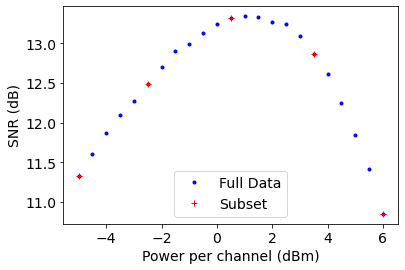

In [4]:
# snr_sub = snr[::2]
# pch_sub = pch[::2]
snr_sub = np.array([snr[0], snr[5], snr[11], snr[17], snr[-1]])
pch_sub = np.array([pch[0], pch[5], pch[11], pch[17], pch[-1]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [5]:
len(snr_sub)

5

In [39]:
def shift_pch(pch, shift):
    pch_shifted = pch - shift
    print("Power shift: %.3f" % shift)
    return pch_shifted
def gen_phys_targets(pch, sigma, num_pts_phys):
    pch_gn_shifted = np.linspace(pch[0], pch[-1], num_pts_phys)
    #model = GN_model(100, 1550, 1, 0.72, 18, 0.18, 35, 40.2, 50, 4.6, 10, -15, sigma, 4)
    #snr_phys = (model.predict_snr(pch_gn_shifted)).reshape(-1,1)
    snr_phys = predict_snr_pvar(pch_gn_shifted, phys_model, 3, sigma).reshape(-1,1)
    return pch_gn_shifted, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):  # note that these GP functions only predict at the data targets
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml
def convert_to_lin(x):
    return 10**(x/10)
def convert_to_db(x):
    return 10*np.log10(x)
def convert_to_dbm(x):
    return 10*np.log10(x/1e-3)
def convert_to_lin_dbm(x):
    return 1e-3*convert_to_lin(x)
def predict_snr_pvar(pch, model, rseed, sig):
    np.random.seed(rseed)
    #pch_pert = convert_to_dbm( np.array([np.random.normal(i, sig) for i in convert_to_lin_dbm(pch)]) )
    try:
        pch_pert = pch + np.random.normal(0, sig, len(pch))
    except:
        pch_pert = pch + np.random.normal(0, sig, 1)
    #pch_pert = pch + np.random.uniform(-sig, sig, len(pch))
    ASE = phys_model.calc_Pase() # W
    Pnli = phys_model.calc_eta(pch_pert)*(convert_to_lin_dbm(pch_pert)**3)
    #trx_btb = 1/31.6
    trx_btb = 1/convert_to_lin(16.)
    return convert_to_db(1/(1/(convert_to_lin_dbm(pch_pert)/(ASE + Pnli)) + trx_btb ))

In [8]:
placeholder = 1

In [19]:
#phys_model = GN_model(100, 1550, 1, 0.72, 18, 0.18, 35, 40.2, 50, 4.6, 10, -trxb2b, nsr_std, 4)
phys_model = GN_model(100, 1550, 1, 0.72, 14, 0.2, 35, 40.2, 50, 4.6, 10, placeholder, placeholder, 4)

In [20]:
shift = 1.0
pch_shifted = shift_pch(pch, shift)

Power shift: 1.000


In [21]:
pch_gn_shifted, snr_phys = gen_phys_targets(pch_shifted, 0.5/3, 10)

In [22]:
pch_sub_shifted = shift_pch(pch_sub, shift)

Power shift: 1.000


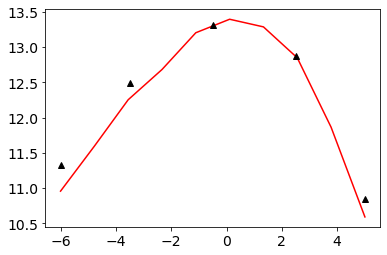

In [23]:
plt.plot(pch_gn_shifted, snr_phys, 'r-')
plt.plot(pch_sub_shifted, snr_sub, 'k^')
plt.show()

In [24]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_sub_shifted, pch_gn_shifted, snr_sub, snr_phys, pch_shifted)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [25]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch_sub_shifted, snr_sub, pch_shifted)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

In [26]:
np.mean(std_sk)

0.8666553523904647

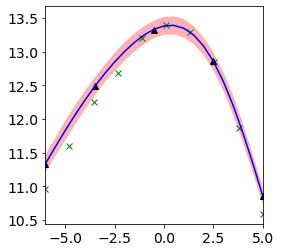

In [28]:
f, ax = plt.subplots()
plt.plot(pch_gn_shifted, snr_phys, 'gx')
plt.plot(pch_sub_shifted, snr_sub, 'k^')
plt.plot(pch_shifted, mu_sk_phys, 'b-')
plt.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.show()

In [31]:
def hyp_var_sig(sig_range, pch, shift, num_pts_phys, snr):
    mus = []
    ls = []
    sigs = []
    lmls = []
    pred_stds = []
    mses = []
    for sig in sig_range:  # sig = std of NSR expressed as a fraction of the NSR mean 
        pch_shifted = shift_pch(pch, shift)
        pch_gn_shifted, snr_phys = gen_phys_targets(pch_shifted, sig, num_pts_phys)
        pred_mean, pred_std, theta_phys, lml_phys = train_phys_gp(pch_sub_shifted, pch_gn_shifted, snr_sub, snr_phys, pch_shifted)
        mus.append(theta_phys[0])
        ls.append(theta_phys[1])
        sigs.append(theta_phys[2])
        lmls.append(lml_phys)
        pred_stds.append(np.mean(pred_std))
        mses.append(calc_mse(snr, pred_mean))
    return mus, ls, sigs, lmls, pred_stds, mses
def hyp_var_num_pts(sigma, pch, shift, num_pts_range, snr):
    mus = []
    ls = []
    sigs = []
    lmls = []
    pred_stds = []
    mses = []
    for num_pts in num_pts_range:
        pch_shifted = shift_pch(pch, shift)
        pch_gn_shifted, snr_phys = gen_phys_targets(pch_shifted, sigma, num_pts)
        pred_mean, pred_std, theta_phys, lml_phys = train_phys_gp(pch_sub_shifted, pch_gn_shifted, snr_sub, snr_phys, pch_shifted)
        mus.append(theta_phys[0])
        ls.append(theta_phys[1])
        sigs.append(theta_phys[2])
        lmls.append(lml_phys)
        pred_stds.append(np.mean(pred_std))
        mses.append(calc_mse(snr, pred_mean))
    return mus, ls, sigs, lmls, pred_stds, mses
def calc_mse(data, y):
    return np.mean(((data - y)**2)**0.5)

In [32]:
sig_range = np.arange(0.1, 0.21, 0.01) 
#sig_range = np.arange(0.01, 0.02, 0.005)
shift = 1.0
mus, ls, sigs, lmls, pred_stds, mses = hyp_var_sig(sig_range, pch, shift, 10, snr)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000


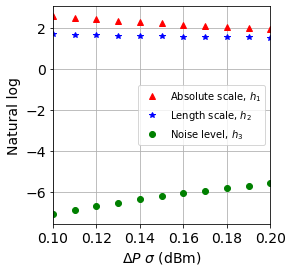

In [33]:
f, ax = plt.subplots()
plt.plot(sig_range, mus, 'r^', label='Absolute scale, $h_1$')
plt.plot(sig_range, ls, 'b*', label='Length scale, $h_2$')
plt.plot(sig_range, sigs, 'go', label='Noise level, $h_3$')
#plt.plot(sig_range, lmls, 'c.', label='Marginal likelihood')
plt.legend(ncol = 1, prop={'size':10})
plt.xlim([sig_range[0], sig_range[-1]])
# plt.xticks([0.005, 0.015, 0.025, 0.035, 0.045, 0.055])
# ax.set_xticklabels([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
# plt.yticks([-8, -6, -4, -2, 0, 2, 4])
#plt.ylim([-8, 4])
plt.xlabel("$\Delta P$ $\sigma$ (dBm)")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_all_pvar05.pdf', dpi=200,bbox_inches='tight')
plt.show()

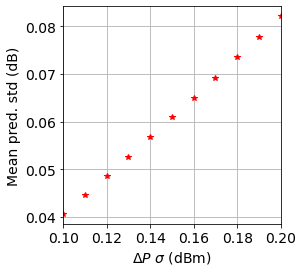

In [34]:
f, ax = plt.subplots()
plt.plot(sig_range, pred_stds, 'r*')
plt.xlim([sig_range[0], sig_range[-1]])
# plt.xticks([0.005, 0.015, 0.025, 0.035, 0.045, 0.055])
# ax.set_xticklabels([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
# plt.yticks([0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05])
#plt.ylim([0.035, 0.08])
plt.xlabel("$\Delta P$ $\sigma$ (dBm)")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.grid()
#plt.savefig('figures/hyp_expl_pred_std_pvar05.pdf', dpi=200,bbox_inches='tight')
plt.show()

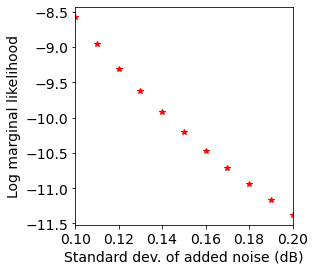

In [35]:
f, ax = plt.subplots()
#plt.plot(sig_range, lin_mus, 'r+', label='Absolute scale')
#plt.plot(sig_range, lin_ls, 'bx', label='Length scale')
plt.plot(sig_range, lmls, 'r*')
#plt.legend(ncol = 2, prop={'size':10})
plt.xlim([sig_range[0], sig_range[-1]])
#plt.xticks([0.01, 0.03, 0.05, 0.07, 0.09, 0.11])
plt.xlabel("Standard dev. of added noise (dB)")
plt.ylabel("Log marginal likelihood")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_lml.pdf', dpi=200,bbox_inches='tight')
plt.show()

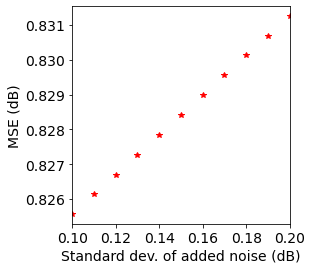

In [36]:
f, ax = plt.subplots()
plt.plot(sig_range, mses, 'r*')
#plt.legend(ncol = 2, prop={'size':10})
plt.xlim([sig_range[0], sig_range[-1]])
#plt.xticks([0.01, 0.03, 0.05, 0.07, 0.09, 0.11])
plt.xlabel("Standard dev. of added noise (dB)")
plt.ylabel("MSE (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_lml.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [40]:
num_pts_range = np.arange(2, 31, 2, dtype=int)
mus_p, ls_p, sigs_p, lmls_p, pred_stds_p, mses_p = hyp_var_num_pts(0.5/3, pch, shift, num_pts_range, snr)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

Power shift: 1.000
Power shift: 1.000
Power shift: 1.000


/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000
Power shift: 1.000


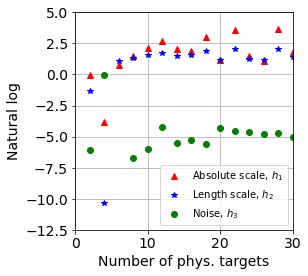

In [41]:
f, ax = plt.subplots()
plt.plot(num_pts_range, mus_p, 'r^', label='Absolute scale, $h_1$')
plt.plot(num_pts_range, ls_p, 'b*', label='Length scale, $h_2$')
plt.plot(num_pts_range, sigs_p, 'go', label='Noise, $h_3$')
#plt.plot(sig_range, lmls, 'c.', label='Marginal likelihood')
plt.legend( prop={'size':10})
plt.xlim([0, 30])
plt.xticks([0, 10, 20, 30])
# plt.yticks([-8, -6, -4, -2, 0, 2, 4, 6])
plt.ylim([-12.5, 5])
plt.xlabel("Number of phys. targets")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_num_pts_all_pvar05.pdf', dpi=200,bbox_inches='tight')
plt.show()

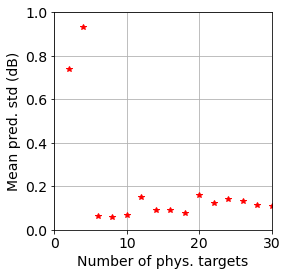

In [42]:
f, ax = plt.subplots()
plt.plot(num_pts_range, pred_stds_p, 'r*')
plt.xlim([0, 30])
#plt.xticks([5, 10, 15, 20, 25, 30])
plt.xticks([0, 10, 20, 30])
# plt.yticks([0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03])
plt.ylim([0, 1.0])
plt.xlabel("Number of phys. targets")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_num_pts_pred_std_pvar05.pdf', dpi=200,bbox_inches='tight')
plt.show()

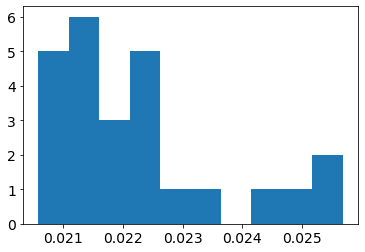

In [112]:
plt.hist(pred_stds_p)
plt.show()

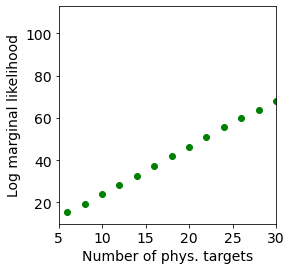

In [125]:
f, ax = plt.subplots()
plt.plot(num_pts_range, lmls_p, 'go')
plt.xlim([5, 30])
plt.xticks([5, 10, 15, 20, 25, 30])
plt.xlabel("Number of phys. targets")
plt.ylabel("Log marginal likelihood")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_num_pts_lml.pdf', dpi=200,bbox_inches='tight')
plt.show()

We expect this behaviour, as the log marginal likelihood scales with the number of points. 

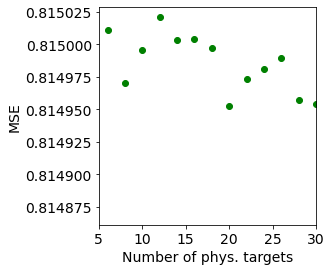

In [126]:
f, ax = plt.subplots()
plt.plot(num_pts_range, mses_p, 'go')
plt.xlim([5, 30])
plt.xticks([5, 10, 15, 20, 25, 30])
plt.xlabel("Number of phys. targets")
plt.ylabel("MSE")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_num_pts_pred_mean.pdf', dpi=200,bbox_inches='tight')
plt.show()

Predictive mean is unchanged to within a precision of 0.001 dB. 